
---

# Análise exploratória de dados: Retail Sales Dataset
Dataset Kaggle: [Retail Sales Dataset](https://www.kaggle.com/datasets/mohammadtalib786/retail-sales-dataset) <br>
Projeto no Kaggle: xxx <br>
Autor: Bruno Pereira <br>

---

## 1. Contexto

**Descrição do Problema/Base de dados:** Este dataset contém dados fictícios de vendas do varejo e caracrerísticas dos compradores, permitindo que consigamos extrair insights além de obter uma compreensão mais profunda do comportamento de compra dos clientes. Meu objetivo é fazer uma análise exploratória desses dados e traduzí-los e insights valiosos. Utilizei como guia os conceitos ensinados pela EBAC(Escola Britânica de Artes e Tecnologia) e principalmente o livro: Estatística Prática para Cientistas de Dados(Autores: Peter Bruce & Andrew Bruce)

Explicação de cada uma das colunas do dataset
1. **Transaction ID(ID da transação):** Um identificador único para cada transação, permitindo rastreamento e referência.

2. **Date(Data):** A data em que a transação ocorreu, fornecendo insights sobre as tendências de vendas ao longo do tempo.

3. **Customer ID(ID do Cliente):** Um identificador exclusivo para cada cliente, permitindo uma análise centrada no cliente.

4. **Gender(Gênero):** O gênero do cliente (masculino/feminino), oferecendo insights sobre padrões de compra baseados em gênero.

5. **Age(Idade):** A idade do cliente, facilitando a segmentação e exploração de influências relacionadas à idade.

6. **Product Category(Categoria do Produto):** A categoria do produto adquirido (Ex.: Eletrônicos, Roupas, Beleza), ajudando a entender as preferências do produto.

7. **Quantity(Quantidade):** O número de unidades do produto adquirido, contribuindo para insights sobre os volumes de compra.

8. **Price per Unit(Preço por Unidade):** O preço de uma unidade do produto, auxiliando nos cálculos relativos ao gasto total.

9. **Total Amount(Montante total):** O valor monetário total da transação, mostrando o impacto financeiro de cada compra.

## 2. Pacotes, bibliotecas & Importações

Pacotes utilizados

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

Funções desenvolvidas que serão utilizadas

In [ ]:
# Definindo palheta de cores fixas para os atributos categóricos
palette_product_category = {
    "Clothing": "#ff9999",   # Vermelho claro
    "Electronics": "#66b3ff", # Azul claro
    "Beauty": "#99ff99"      # Verde claro
}

palete_gender = {
    'Female': "#f25f9a", # Rosa claro
    'Male': "#e6f4f1" # Branco
}

# Função utilizada para verificar os valores únicos
def verifica_valores_unicos(DataFrame: pd.DataFrame, colunas_ignoradas: list|str|None) -> None:
    for x in DataFrame.columns:
    
        if type(colunas_ignoradas) == str:
            if x != colunas_ignoradas:
                print('++'*30)
                print(f'NOME DA COLUNA COLUNA: "{x}"')
                print('--'*5)
                print('VALORES ÚNICOS:')
                print(f'{DataFrame[x].unique()}')
                print('--'*5)
                print(f'CONTAGEM DOS VALORES ÚNICOS: {len(DataFrame[x].unique())}')
                print('++'*30)
                print('\n')
        
        elif type(colunas_ignoradas) == list:
            if x not in colunas_ignoradas:
                print('++'*30)
                print(f'NOME DA COLUNA COLUNA: "{x}"')
                print('--'*5)
                print('VALORES ÚNICOS:')
                print(f'{DataFrame[x].unique()}')
                print('--'*5)
                print(f'CONTAGEM DOS VALORES ÚNICOS: {len(DataFrame[x].unique())}')
                print('++'*30)
                print('\n')

        else:
            print('++'*30)
            print(f'NOME DA COLUNA COLUNA: "{x}"')
            print('--'*5)
            print('VALORES ÚNICOS:')
            print(f'{DataFrame[x].unique()}')
            print('--'*5)
            print(f'CONTAGEM DOS VALORES ÚNICOS: {len(DataFrame[x].unique())}')
            print('++'*30)
            print('\n')

# Cria o rótulo de dados de cada barra (No topo da barra)
def cria_rotulos_barras(histrgrama, grid, posicao_grid: int, fontsize: int, binwidth_value: int) -> None:
    
    for p in histrgrama.patches:
        
        height = p.get_height() # 'Altura' da barra, nesse caso a frequência
        
        # Adicionar rótulo da frequência (no topo da barra)
        if height != 0: # Não adiciona o rótulo caso a barra exteja com o valor zerado
            grid[posicao_grid].annotate(f"{int(height)}", 
                            (p.get_x() + binwidth_value / 2, height + 1), 
                            ha="center", fontsize=fontsize, fontweight="bold")

# Cria o rótulo do intervalo de cada bin do histograma (Dentro da barra)
def rotula_intervalo_bins(histrgrama, grid ,posicao_grid: int, fontsize: int, binwidth_value: int) -> None:

    for position, p in enumerate(histrgrama.patches):
        
        height = p.get_height() # 'Altura' da barra, nesse caso a frequência
        
        if position == 0:
            bin_left = p.get_x() # Valor que inicia o intervalo
            bin_right = bin_left + binwidth_value # Valor que finaliza o intervalo
        else: # Adicionado essa tratativa para que o o último valor do rótulo da barra não seja o mesmo que o primeiro valor da próxima barra
            bin_left = p.get_x() + 1 
            bin_right = bin_left + binwidth_value - 1 # Valor que finaliza o intervalo

        bin_range_label = f"{int(bin_left)} - {int(bin_right)}"

        if height != 0: # Não adiciona o rótulo caso a barra exteja com o valor zerado
            # Adicionar rótulo do intervalo (dentro da barra)
            grid[posicao_grid].annotate(bin_range_label, 
                            (p.get_x() + binwidth_value / 2, height / 2), 
                            ha='center', va='center', fontsize=fontsize, color='black', rotation=90)

# Cria o rótulo percentual de cada um dos segmentos das barras (Dentro da barra)
def rotula_percentual_segmentado_barras(histograma, grid, posicao_grid:int, fontsize: int) -> None:

    # Criar um dicionário para armazenar a soma de valores de cada bin
    bin_totals = {}

    # Primeira passada para obter os totais por bin
    for patch in histograma.patches:
        x_start = patch.get_x()
        x_end = x_start + patch.get_width()
        bin_mid = (x_start + x_end) / 2  # Centro do bin

        if bin_mid not in bin_totals:
            bin_totals[bin_mid] = 0
        bin_totals[bin_mid] += patch.get_height()  # Soma os valores do bin

    # Segunda passada para adicionar os rótulos percentuais
    for patch in histograma.patches:
        height = patch.get_height()
        x_start = patch.get_x()
        x_end = x_start + patch.get_width()
        bin_mid = (x_start + x_end) / 2  # Centro do bin

        if height > 0:
            percent = (height / bin_totals[bin_mid]) * 100  # Calcula percentual
            grid[posicao_grid].text(bin_mid, patch.get_y() + height / 2, f'{percent:.1f}%', ha='center', va='center', fontsize=fontsize, color='black', rotation=90)

## 3. Exploração Inicial dos dados

Leitura do dataset

In [5]:
df = pd.read_csv("../Retail Sales Dataset.csv")

Visualização inicial dos dados

In [6]:
df.head()

,Transaction ID,Date,Customer ID,Gender,Age,Product Category,Quantity,Price per Unit,Total Amount
0,1,2023-11-24,CUST001,Male,34,Beauty,3,50,150
1,2,2023-02-27,CUST002,Female,26,Clothing,2,500,1000
2,3,2023-01-13,CUST003,Male,50,Electronics,1,30,30
3,4,2023-05-21,CUST004,Male,37,Clothing,1,500,500
4,5,2023-05-06,CUST005,Male,30,Beauty,2,50,100


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Transaction ID    1000 non-null   int64 
 1   Date              1000 non-null   object
 2   Customer ID       1000 non-null   object
 3   Gender            1000 non-null   object
 4   Age               1000 non-null   int64 
 5   Product Category  1000 non-null   object
 6   Quantity          1000 non-null   int64 
 7   Price per Unit    1000 non-null   int64 
 8   Total Amount      1000 non-null   int64 
dtypes: int64(5), object(4)
memory usage: 70.4+ KB


**Conclusão:** Podemos notar que o DataFrame é bom limpo e consistente, sendo necessário apenas algumas conversões do tipo de alguns dados e talvez excluir algumas colunas. Notamos também que a maioria dos atributos são do tipo numérico, especificamente numéricos discretos(```Total Amount```, ```Price per Unit```, ```Quantity```, ```Age```, ```Transaction ID```). Também existem duas colunas categóricas nominais(```Customer ID```, ```Gender```, ```Product Category```), e uma coluna de data(```Date```).

Utilização da função ```verifica_valores_unicos``` para entendermos mais profundamente como estão distribuídos os dados em cada um dos atributos

In [8]:
verifica_valores_unicos(df, colunas_ignoradas=['Date','Price per Unit','Total Amount'])

++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
NOME DA COLUNA COLUNA: "Transaction ID"
----------
VALORES ÚNICOS:
[   1    2    3    4    5    6    7    8    9   10   11   12   13   14
   15   16   17   18   19   20   21   22   23   24   25   26   27   28
   29   30   31   32   33   34   35   36   37   38   39   40   41   42
   43   44   45   46   47   48   49   50   51   52   53   54   55   56
   57   58   59   60   61   62   63   64   65   66   67   68   69   70
   71   72   73   74   75   76   77   78   79   80   81   82   83   84
   85   86   87   88   89   90   91   92   93   94   95   96   97   98
   99  100  101  102  103  104  105  106  107  108  109  110  111  112
  113  114  115  116  117  118  119  120  121  122  123  124  125  126
  127  128  129  130  131  132  133  134  135  136  137  138  139  140
  141  142  143  144  145  146  147  148  149  150  151  152  153  154
  155  156  157  158  159  160  161  162  163  164  165  166  167  168
  169  170  171  172

Também existe uma coluna de data, vamos entender inicialmente o período temporal que esse dataset contempla

In [9]:
df['Date'].min(), df['Date'].max()

('2023-01-01', '2024-01-01')

## 4. Wrangling

Depois dessa breve análise faremos alguns tratamentos, iniciando com a exclusão de algumas colunas que não impactarão em nossas futuras análises, sendo elas: ```Customer ID``` e ```Transaction ID```

In [10]:
df.drop(columns=['Transaction ID', 'Customer ID'], inplace=True)

Também faremos as conversão dos valores dos atributos para seus respectivos tipos, isso deixa nossa base de dados mais otimizada consumindo menos recusos computacionais, por mais que nossa base é pequena é uma boa prática.

In [11]:
df['Date'] = pd.to_datetime(df['Date']) # Converter de object para datetime
df['Gender'] = df['Gender'].astype("category") # Converter de object para o tipo category
df['Product Category'] = df['Product Category'].astype("category") # Converter de object para o tipo category

In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   Date              1000 non-null   datetime64[ns]
 1   Gender            1000 non-null   category      
 2   Age               1000 non-null   int64         
 3   Product Category  1000 non-null   category      
 4   Quantity          1000 non-null   int64         
 5   Price per Unit    1000 non-null   int64         
 6   Total Amount      1000 non-null   int64         
dtypes: category(2), datetime64[ns](1), int64(4)
memory usage: 41.4 KB


## Análise Exploratória

### Análise dos Atributos Categóricos

#### Atributo: ```Gender``` & ```Product Category```

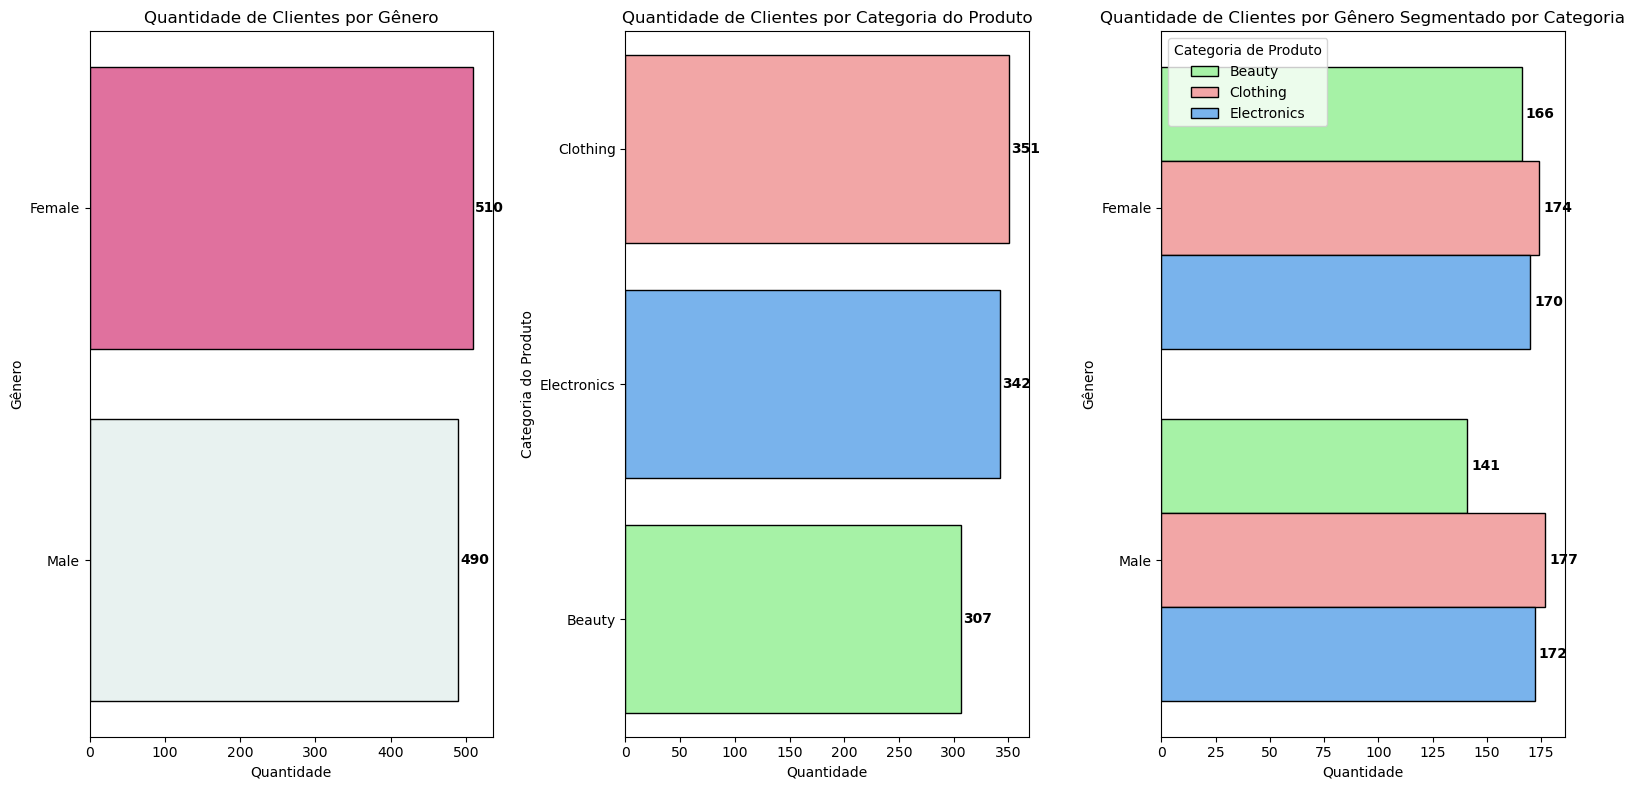

In [ ]:
# Criar a figura com três gráficos lado a lado
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(16, 8))

# 🎯 Gráfico 1: Quantidade de Clientes por Gênero
gender_order = df["Gender"].value_counts().index  # Ordenar categorias pela contagem
sns.countplot(data=df, y="Gender", palette=palete_gender, edgecolor="black", ax=axes[0],order=gender_order)
axes[0].set_title("Quantidade de Clientes por Gênero", fontsize=12)
axes[0].set_xlabel("Quantidade", fontsize=10)
axes[0].set_ylabel("Gênero", fontsize=10)

# Adicionar rótulos de valores dentro das barras
for p in axes[0].patches:
    axes[0].annotate(f'{int(p.get_width())}', 
                     (p.get_width() + 2, p.get_y() + p.get_height()/2), 
                     ha='left', va='center', fontsize=10, fontweight="bold")

# 🎯 Gráfico 2: Quantidade de Clientes por Categoria do Produto (Ordenado)
product_category_order = df["Product Category"].value_counts().index  # Ordenar categorias pela contagem
sns.countplot(data=df, y="Product Category", palette=palette_product_category, edgecolor="black", ax=axes[1], order=product_category_order)
axes[1].set_title("Quantidade de Clientes por Categoria do Produto", fontsize=12)
axes[1].set_xlabel("Quantidade", fontsize=10)
axes[1].set_ylabel("Categoria do Produto", fontsize=10)

# Adicionar rótulos de valores dentro das barras
for p in axes[1].patches:
    axes[1].annotate(f'{int(p.get_width())}', 
                     (p.get_width() + 2, p.get_y() + p.get_height()/2), 
                     ha='left', va='center', fontsize=10, fontweight="bold")

# 🎯 Gráfico 3: Quantidade de Clientes por Gênero Segmentado pelo Product Category
sns.countplot(data=df, y="Gender", hue="Product Category", palette=palette_product_category, edgecolor="black", ax=axes[2])
axes[2].set_title("Quantidade de Clientes por Gênero Segmentado por Categoria", fontsize=12)
axes[2].set_xlabel("Quantidade", fontsize=10)
axes[2].set_ylabel("Gênero", fontsize=10)
axes[2].legend(title="Categoria de Produto", loc="upper left")  # Mover legenda para o canto superior esquerdo

# Adicionar rótulos de valores dentro das barras do gráfico 3
for p in axes[2].patches:
    axes[2].annotate(f'{int(p.get_width())}', 
                     (p.get_width() + 2, p.get_y() + p.get_height()/2), 
                     ha='left', va='center', fontsize=10, fontweight="bold")

# Ajustar layout
plt.tight_layout()
plt.show()


**Explicação**: Podemos notar que as categorias da nossa base de dados estão bem distribuídas, sem um valor muito discrepante dos demais. Observando o atributo gênero, notamos que nossa amostra possui 2% mais clientes mulheres do que homens. O atributo Categoria do Produto, possui mais produtos do tipo Clothing(Roupas). Analisando a quantidade de produtos adquiridos segmentados por gênero e por Categoria do produto, notamos uma distribuição bem harmônica, porém com os homens comprando menos protudos de Beleza do que as mulheres.

### Análise exploratória dos atributos Numéricos

#### Atributo: ```Age```

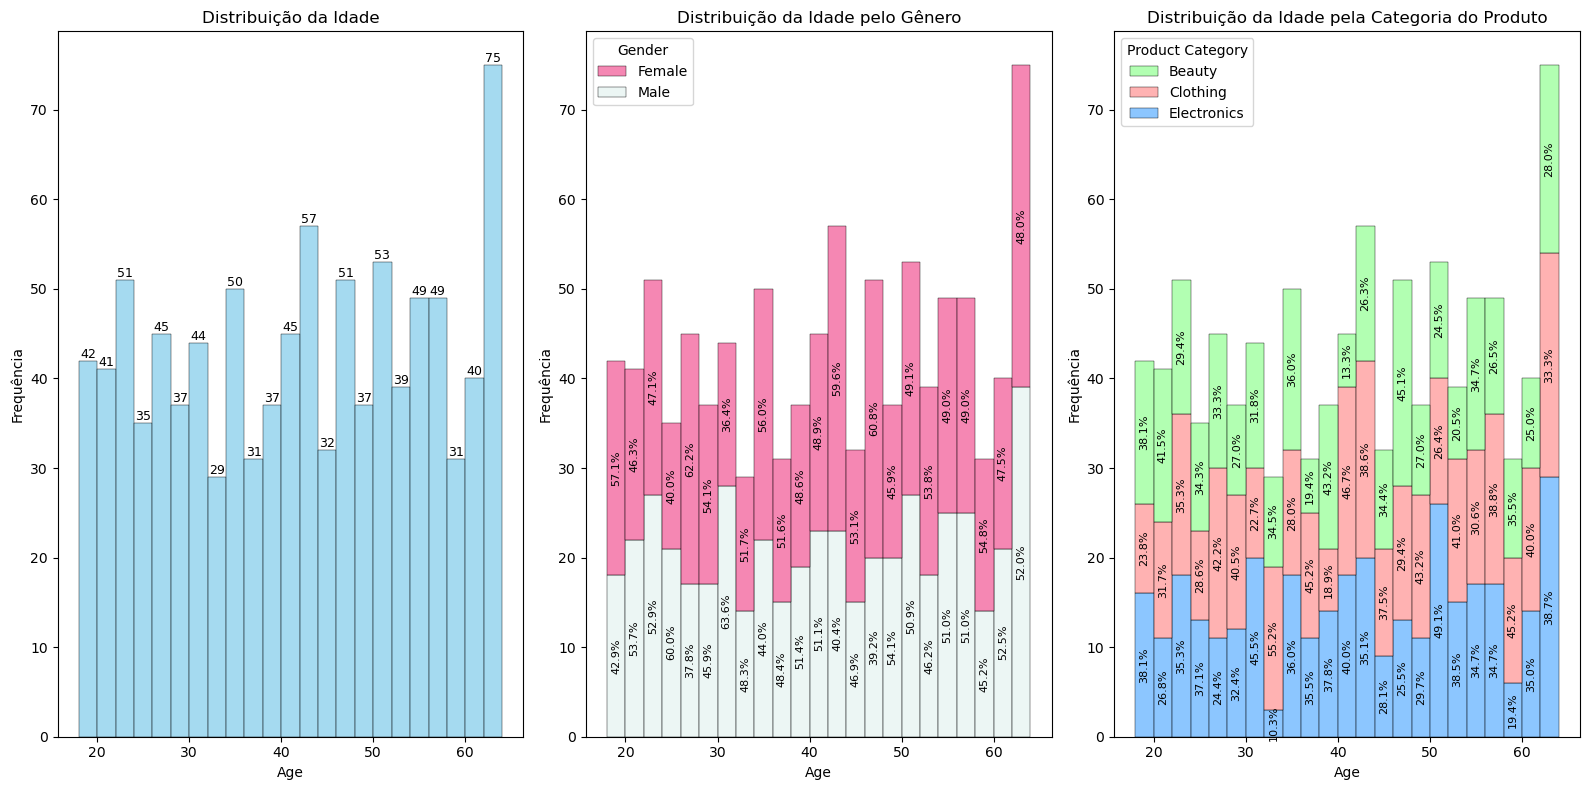

In [ ]:
# Criação dos Grids 3x2
janela, graficos = plt.subplots(nrows=1, ncols=3, figsize=(16,8))

# Gráfico 1
#-----------

# Criação do histograma
histplot = sns.histplot(data=df, x='Age', binwidth=2, ax=graficos[0], edgecolor="black", linewidth=0.3, color='skyblue')

# Adicionando rótulos de dados nos bins
for patch in histplot.patches:
    height = patch.get_height()  # Obtém a altura da barra (frequência)
    if height > 0:  # Apenas exibe se houver valor
        x_position = patch.get_x() + patch.get_width() / 2  # Define a posição no centro do bin
        graficos[0].text(x_position, height, f'{int(height)}', ha='center', va='bottom', fontsize=9, color='black')

# Customizações adicionais do gráfico 1
graficos[0].set_title('Distribuição da Idade', fontsize=12)
graficos[0].set_xlabel('Age', fontsize=10)
graficos[0].set_ylabel('Frequência', fontsize=10)

# 📌 Gráfico 2 (Frequência + Percentuais por Gender)
histplot2 = sns.histplot(data=df, x='Age', hue='Gender', binwidth=2, multiple="stack", ax=graficos[1], edgecolor="black", linewidth=0.3, palette=palete_gender)

# Criar um dicionário para armazenar a soma de valores de cada bin
bin_totals = {}

# Primeira passada para obter os totais por bin
for patch in histplot2.patches:
    x_start = patch.get_x()
    x_end = x_start + patch.get_width()
    bin_mid = (x_start + x_end) / 2  # Centro do bin

    if bin_mid not in bin_totals:
        bin_totals[bin_mid] = 0
    bin_totals[bin_mid] += patch.get_height()  # Soma os valores do bin

# Segunda passada para adicionar os rótulos percentuais
for patch in histplot2.patches:
    height = patch.get_height()
    x_start = patch.get_x()
    x_end = x_start + patch.get_width()
    bin_mid = (x_start + x_end) / 2  # Centro do bin

    if height > 0:
        percent = (height / bin_totals[bin_mid]) * 100  # Calcula percentual
        graficos[1].text(bin_mid, patch.get_y() + height / 2, f'{percent:.1f}%', ha='center', va='center', fontsize=8, color='black', rotation=90)

# Customizações adicionais do gráfico 1
graficos[1].set_title('Distribuição da Idade pelo Gênero', fontsize=12)
graficos[1].set_xlabel('Age', fontsize=10)
graficos[1].set_ylabel('Frequência', fontsize=10)

# Criação do gráfico 3
histplot3 = sns.histplot(data=df, x='Age', hue='Product Category', binwidth=2,  multiple="stack", ax=graficos[2], edgecolor="black", linewidth=0.3, palette=palette_product_category)

# Criar um dicionário para armazenar a soma de valores de cada bin
bin_totals = {}

# Primeira passada para obter os totais por bin
for patch in histplot3.patches:
    x_start = patch.get_x()
    x_end = x_start + patch.get_width()
    bin_mid = (x_start + x_end) / 2  # Centro do bin

    if bin_mid not in bin_totals:
        bin_totals[bin_mid] = 0
    bin_totals[bin_mid] += patch.get_height()  # Soma os valores do bin

# Segunda passada para adicionar os rótulos percentuais
for patch in histplot3.patches:
    height = patch.get_height()
    x_start = patch.get_x()
    x_end = x_start + patch.get_width()
    bin_mid = (x_start + x_end) / 2  # Centro do bin

    if height > 0:
        percent = (height / bin_totals[bin_mid]) * 100  # Calcula percentual
        graficos[2].text(bin_mid, patch.get_y() + height / 2, f'{percent:.1f}%', ha='center', va='center', fontsize=8, color='black', rotation=90)

# Customizações adicionais do gráfico 1
graficos[2].set_title('Distribuição da Idade pela Categoria do Produto', fontsize=12)
graficos[2].set_xlabel('Age', fontsize=10)
graficos[2].set_ylabel('Frequência', fontsize=10)
# Exibir os gráficos
plt.tight_layout()
plt.show()

In [31]:
maior_frequencia_etaria = (len(df.query("Age >= 62 and Age <= 64")) / len(df)) * 100
print(f'A faixa etária entre 62 e 64 anos representa {maior_frequencia_etaria}% da nossa base de dados')

A faixa etária entre 62 e 64 anos representa 7.5% da nossa base de dados


**Explicação**: Notamos que toda a amostra possui clientes acima de 18 anos, com a amplitude etária entre 18 anos e 64 anos. Nota-se principalmente que a faixa etária com maior quantidade de clientes em nossa amostra é entre 62 a 64 anos, representando 7,5% de toda nossa base. Observamos também que não há um insight claro que podemos tirar segmentando pela idade ou pela categoria do produto.

#### Atributo: ```Quantity```

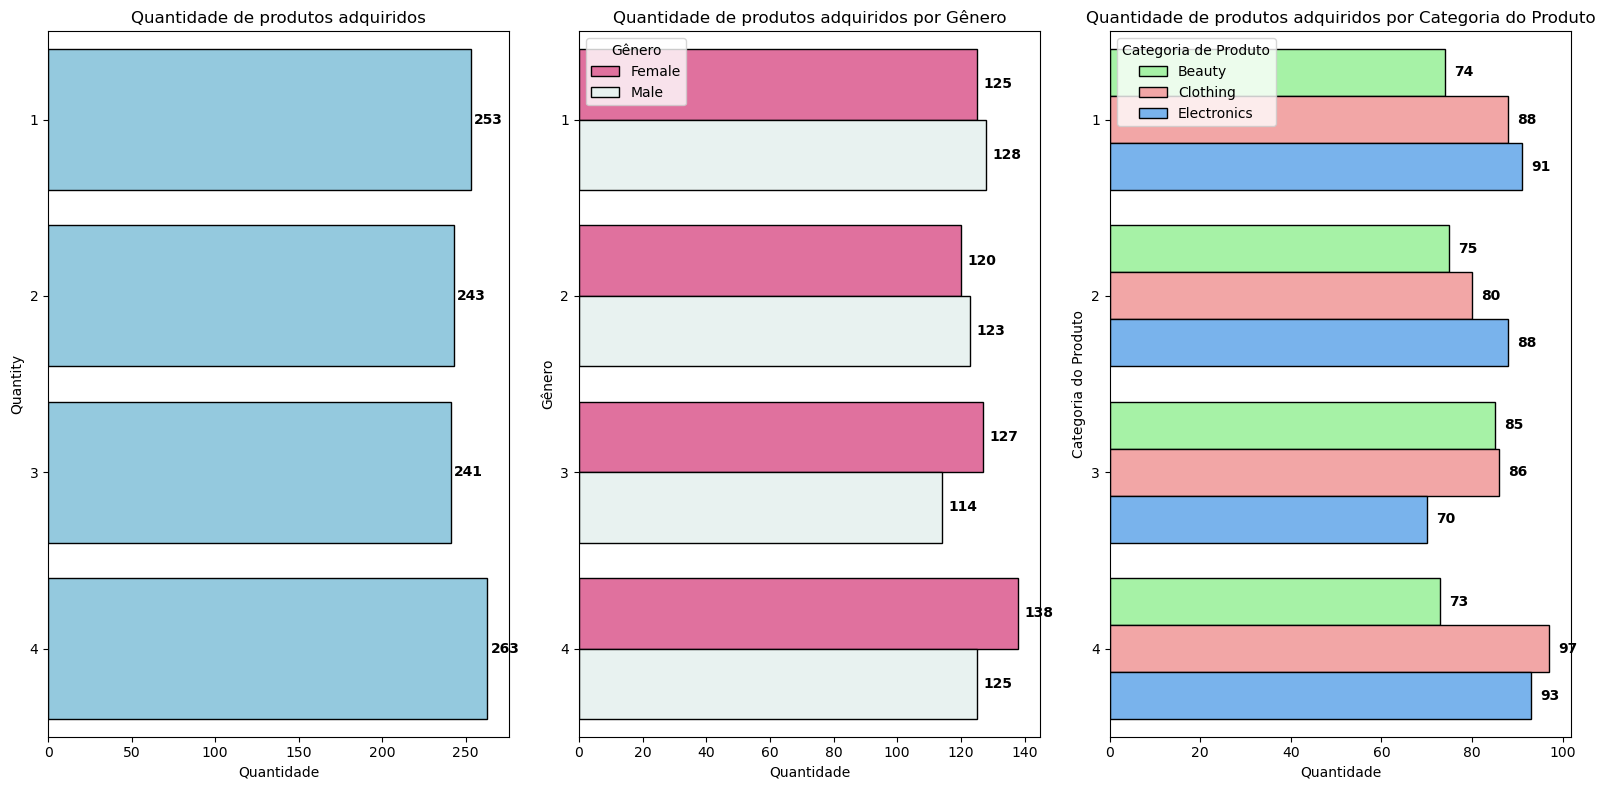

In [13]:
# Criar a figura com três gráficos lado a lado
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(16, 8))

# 🎯 Gráfico 1: Quantidade de produtos adquiridos
sns.countplot(data=df, y="Quantity", color='skyblue', edgecolor="black", ax=axes[0])
axes[0].set_title("Quantidade de produtos adquiridos", fontsize=12)
axes[0].set_xlabel("Quantidade", fontsize=10)
axes[0].set_ylabel("Quantity", fontsize=10)

# Adicionar rótulos de valores dentro das barras
for p in axes[0].patches:
    axes[0].annotate(f'{int(p.get_width())}', 
                     (p.get_width() + 2, p.get_y() + p.get_height()/2), 
                     ha='left', va='center', fontsize=10, fontweight="bold")

# 🎯 Gráfico 2: Quantidade de produtos adquiridos segmentados por Gênero
sns.countplot(data=df, y="Quantity", hue="Gender", edgecolor="black", ax=axes[1], palette=palete_gender)
axes[1].set_title("Quantidade de produtos adquiridos por Gênero", fontsize=12)
axes[1].set_xlabel("Quantidade", fontsize=10)
axes[1].set_ylabel("Gênero", fontsize=10)
axes[1].legend(title="Gênero", loc="upper left")

# Adicionar rótulos de valores dentro das barras do gráfico 3
for p in axes[1].patches:
    axes[1].annotate(f'{int(p.get_width())}', 
                     (p.get_width() + 2, p.get_y() + p.get_height()/2), 
                     ha='left', va='center', fontsize=10, fontweight="bold")


# 🎯 Gráfico 3: Quantidade de produtos adquiridos segmentados por categoria
sns.countplot(data=df, y="Quantity", hue="Product Category", edgecolor="black", ax=axes[2], palette=palette_product_category)
axes[2].set_title("Quantidade de produtos adquiridos por Categoria do Produto", fontsize=12)
axes[2].set_xlabel("Quantidade", fontsize=10)
axes[2].set_ylabel("Categoria do Produto", fontsize=10)
axes[2].legend(title="Categoria de Produto", loc="upper left")

# Adicionar rótulos de valores dentro das barras
for p in axes[2].patches:
    axes[2].annotate(f'{int(p.get_width())}', 
                     (p.get_width() + 2, p.get_y() + p.get_height()/2), 
                     ha='left', va='center', fontsize=10, fontweight="bold")


# Ajustar layout
plt.tight_layout()
plt.show()


**Explicação** Podemos observar alguns detalhes interessantes:
1. Na nossa amostra, os consumidores tem um comportamento de comprar mais de um produto, 4 produtos para ser mais específico;
2. A maior quantidade de produtos comprados se dá pelo público feminino, sendo a categoria ```Beauty``` a com menos produtos comprados de uma só vez

#### Atributo: ```Total Amount```

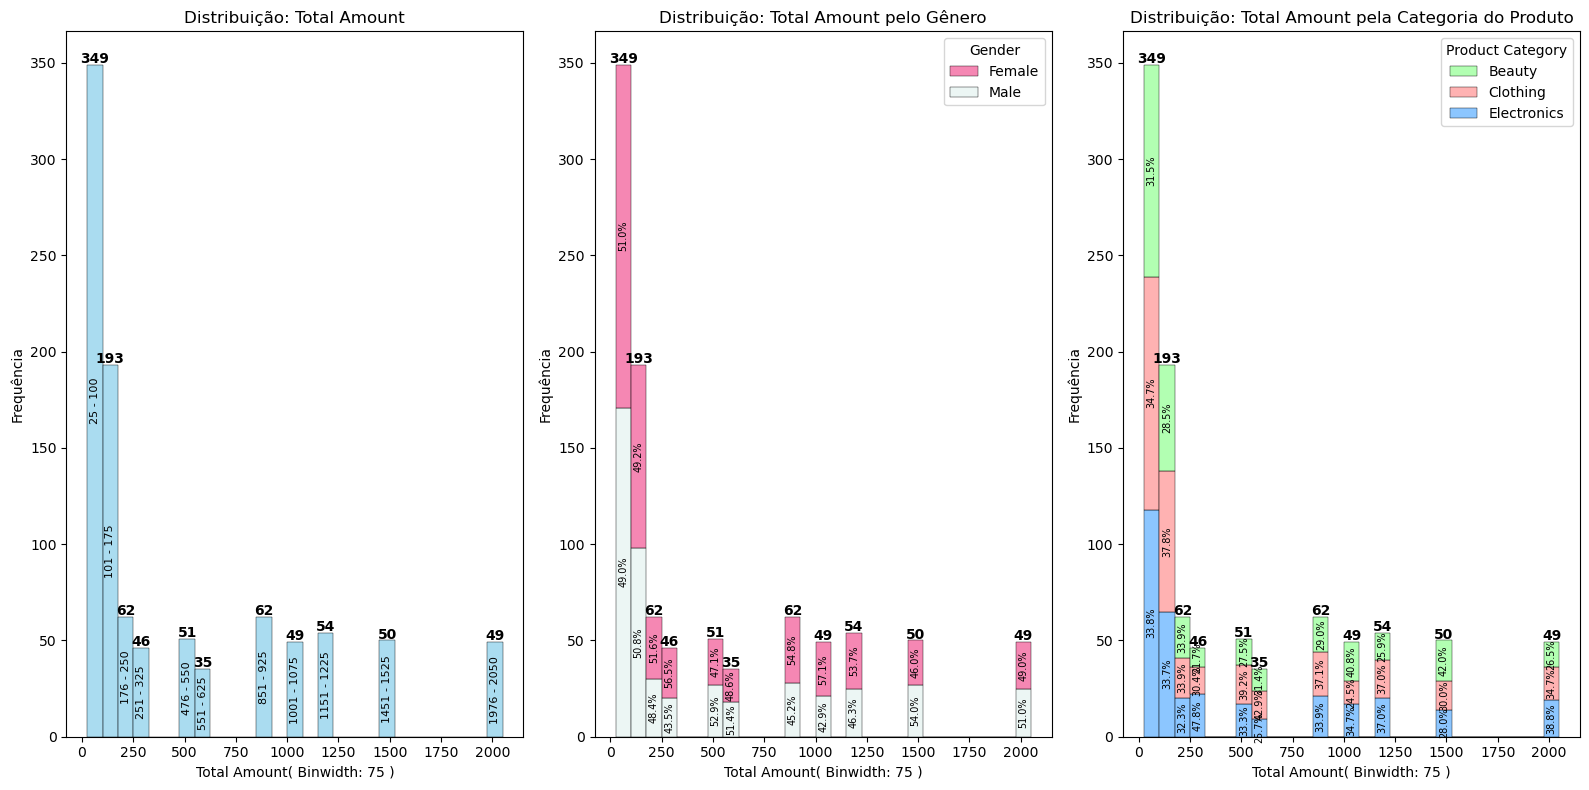

In [ ]:
# Criação dos Grids 3x2
janela, graficos = plt.subplots(nrows=1, ncols=3, figsize=(16,8))

# Gráfico 1
#-----------
binwidth_value = 75  # Defina o tamanho do intervalo
fontsize = 7

histplot = sns.histplot(data=df, x='Total Amount', binwidth=binwidth_value, ax=graficos[0], edgecolor="black", alpha=0.7, linewidth=0.3, color='skyblue')
graficos[0].set_title('Distribuição: Total Amount', fontsize=12)
graficos[0].set_xlabel(f'Total Amount( Binwidth: {binwidth_value} )', fontsize=10)
graficos[0].set_ylabel("Frequência", fontsize=10)

cria_rotulos_barras(histrgrama=histplot, grid=graficos, posicao_grid=0, fontsize= 10, binwidth_value=binwidth_value)

rotula_intervalo_bins(histrgrama=histplot, grid=graficos, posicao_grid=0, fontsize=8, binwidth_value=binwidth_value)

# 📌 Gráfico 2 (Frequência + Percentuais por Gender)
histplot2 = sns.histplot(data=df, x='Total Amount', hue='Gender', binwidth=binwidth_value, multiple="stack", ax=graficos[1], edgecolor="black", linewidth=0.3, palette=palete_gender)

cria_rotulos_barras(histrgrama=histplot, grid=graficos, posicao_grid=1, fontsize= 10, binwidth_value=binwidth_value)

rotula_percentual_segmentado_barras(histograma=histplot2, grid=graficos, posicao_grid=1, fontsize=7)

# Customizações adicionais do gráfico 1
graficos[1].set_title('Distribuição: Total Amount pelo Gênero', fontsize=12)
graficos[1].set_xlabel(f'Total Amount( Binwidth: {binwidth_value} )', fontsize=10)
graficos[1].set_ylabel('Frequência', fontsize=10)

# Criação do gráfico 3
histplot3 = sns.histplot(data=df, x='Total Amount', hue='Product Category', binwidth=binwidth_value,  multiple="stack", ax=graficos[2], edgecolor="black", linewidth=0.3, palette=palette_product_category)

cria_rotulos_barras(histrgrama=histplot, grid=graficos, posicao_grid=2, fontsize= 10, binwidth_value=binwidth_value)

rotula_percentual_segmentado_barras(histograma=histplot3, grid=graficos, posicao_grid=2, fontsize=7)

# Customizações adicionais do gráfico 1
graficos[2].set_title('Distribuição: Total Amount pela Categoria do Produto', fontsize=12)
graficos[2].set_xlabel(f'Total Amount( Binwidth: {binwidth_value} )', fontsize=10)
graficos[2].set_ylabel('Frequência', fontsize=10)

# Exibir os gráficos
plt.tight_layout()
plt.show()

In [15]:
df_amount_menor_500 = df[df['Total Amount'] <= 500]
len(df_amount_menor_500)

701

**Explicação:** Analisando o atributo ```Total Amount``` podemos notar que os dados estão distribuídos mais a esquerda do gráfico(Valores menores), mais especificamente 70% de toda nossa base possui o ```Total Amount``` menor ou igual a 700, podemos dar um 'zoom in' para conseguirmos endender melhor como tais valores se comportam empregando o maior esforço para analisar onde está a maior parte dos dados. Segmentando os dados pele ```Gender``` notamos que não há uma distribuição bem igualitária, situação que se repete ao analisarmos a categoria ```Product Category```

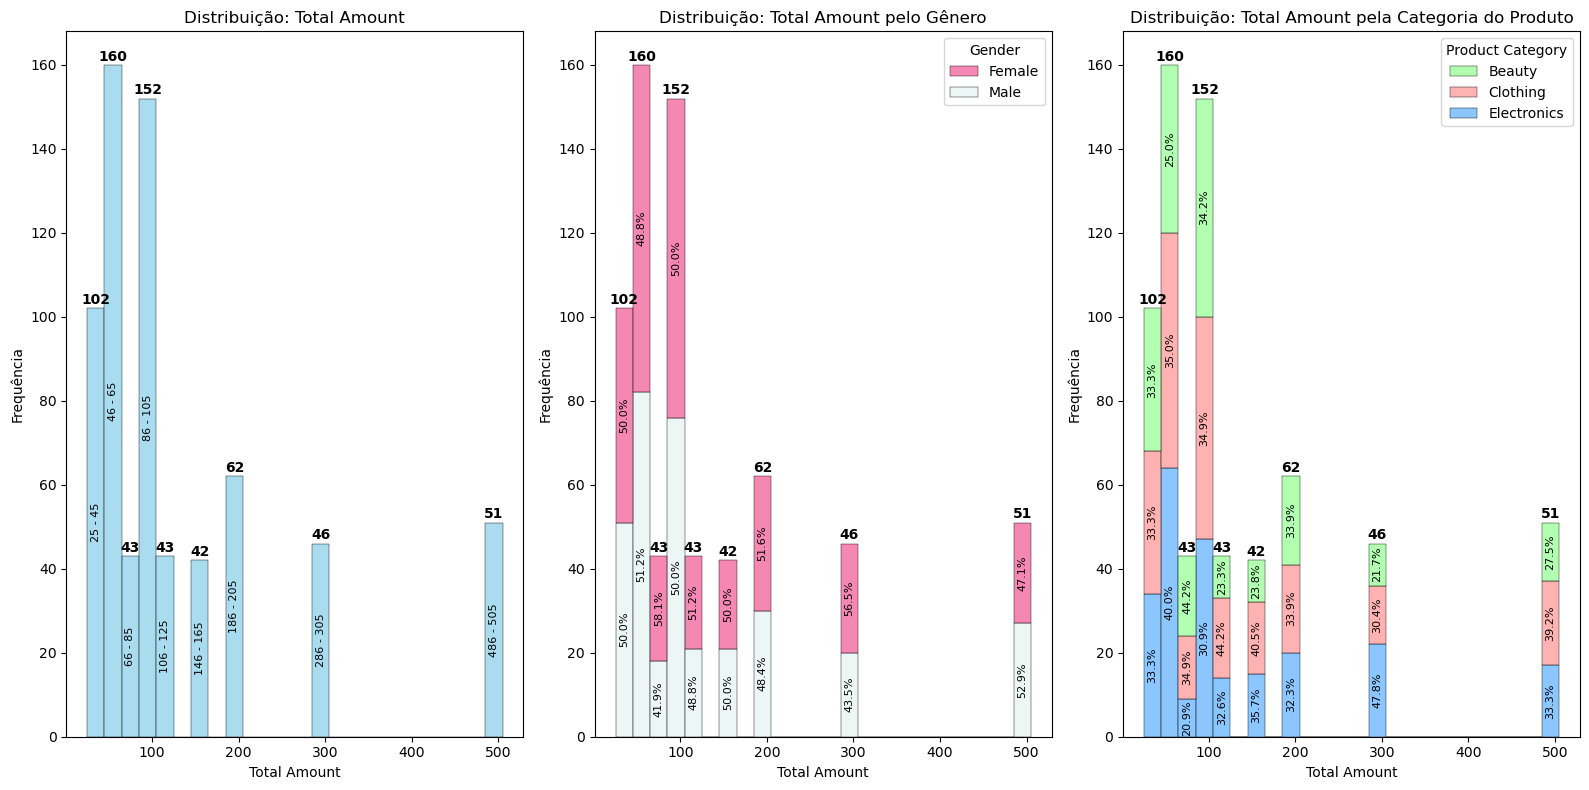

In [ ]:
# Criação dos Grids 1x3
janela, graficos = plt.subplots(nrows=1, ncols=3, figsize=(16,8))

# Gráfico 1 (Histograma do Total Amount limitado a 500)
#-----------
binwidth_value = 20  # Defina o tamanho do intervalo

histplot = sns.histplot(data=df_amount_menor_500, x='Total Amount', binwidth=binwidth_value, ax=graficos[0], color='skyblue', edgecolor="black", alpha=0.7, linewidth=0.3)
graficos[0].set_title('Distribuição: Total Amount', fontsize=12)
graficos[0].set_xlabel('Total Amount', fontsize=10)
graficos[0].set_ylabel("Frequência", fontsize=10)

cria_rotulos_barras(histrgrama=histplot, grid=graficos, posicao_grid=0, fontsize= 10, binwidth_value=20)

rotula_intervalo_bins(histrgrama=histplot, grid=graficos, posicao_grid=0, fontsize=8, binwidth_value=20)

# 📌 Gráfico 2 (Frequência + Percentuais por Gender)
histplot2 = sns.histplot(data=df_amount_menor_500, x='Total Amount', hue='Gender', binwidth=20, multiple="stack", ax=graficos[1], edgecolor="black", linewidth=0.3, palette=palete_gender)

cria_rotulos_barras(histrgrama=histplot, grid=graficos, posicao_grid=1, fontsize= 10, binwidth_value=20)

rotula_percentual_segmentado_barras(histograma=histplot2, grid=graficos, posicao_grid=1, fontsize=8)

# Customizações adicionais do gráfico 1
graficos[1].set_title('Distribuição: Total Amount pelo Gênero', fontsize=12)
graficos[1].set_xlabel('Total Amount', fontsize=10)
graficos[1].set_ylabel('Frequência', fontsize=10)

# Criação do gráfico 3
histplot3 = sns.histplot(data=df_amount_menor_500, x='Total Amount', hue='Product Category', binwidth=20,  multiple="stack", ax=graficos[2], edgecolor="black", linewidth=0.3, palette=palette_product_category)

cria_rotulos_barras(histrgrama=histplot, grid=graficos, posicao_grid=2, fontsize= 10, binwidth_value=20)

rotula_percentual_segmentado_barras(histograma=histplot3, grid=graficos, posicao_grid=2, fontsize=8)

# Customizações adicionais do gráfico 1
graficos[2].set_title('Distribuição: Total Amount pela Categoria do Produto', fontsize=12)
graficos[2].set_xlabel('Total Amount', fontsize=10)
graficos[2].set_ylabel('Frequência', fontsize=10)

# Exibir os gráficos
plt.tight_layout()
plt.show()

**Explicação**: Podemos notar que a maior frequência de Total Amount se contrenta entre 46 a 65, e 86 a 105. Esse já é um insight interessante pois poderíamos fazer alguma ação de marketing ou oferecer algum desconto para clientes desses nichos.

In [63]:
df_teste['Product Category'].value_counts()

Product Category
Electronics    98
Clothing       90
Beauty         74
Name: count, dtype: int64

<Axes: xlabel='Price per Unit', ylabel='Quantity'>

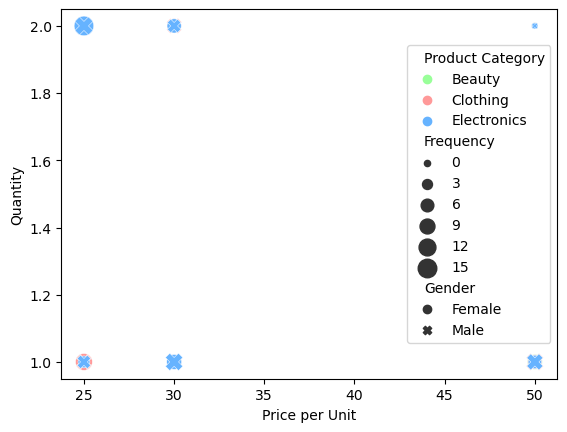

In [57]:
df_teste = df[(df['Total Amount'] >= 25) & (df['Total Amount'] <= 65)]

# Contar a frequência de cada par único de (Price per Unit, Quantity)
df_freq = df_teste.groupby(['Price per Unit', 'Quantity', 'Product Category', 'Gender']).size().reset_index(name='Frequency')

# Criar scatterplot com tamanho baseado na frequência
sns.scatterplot(data=df_freq, 
                x='Price per Unit', 
                y='Quantity', 
                hue='Product Category', 
                palette=palette_product_category,
                style='Gender',
                size='Frequency',  # Ajusta o tamanho conforme a frequência
                sizes=(20, 200))  # Ajusta o intervalo de tamanho das bolhas

<Axes: xlabel='Price per Unit', ylabel='Quantity'>

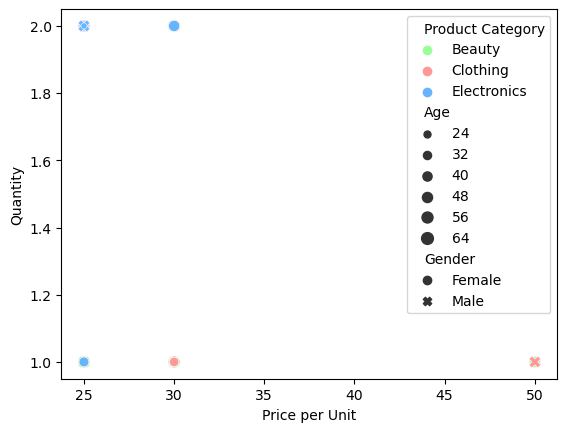

In [60]:
# Criar scatterplot com tamanho baseado na frequência
sns.scatterplot(data=df_teste, 
                x='Price per Unit', 
                y='Quantity', 
                hue='Product Category', 
                palette=palette_product_category,
                style='Gender',
                size='Age')  # Ajusta o intervalo de tamanho das bolhas

### Análise pelas compras ao longo do tempo

#### Atributo: ```Date```